In [1]:
import simpy
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

from package import demand, pricing, inventory, hurricane
%matplotlib inline

### Experiment Goals
1. pricing strategy: constant price / linear price
2. the effect of hurricane, we assume all hurricane will make a 5 days orange price strike
3. refill strategy: refill our inventory when the inventory volume is only 15%, 10%, or 8%

### basic settings
1. orange price is the `Orange Juice Futures Historical Data.csv`
2. we always refill 50 unit of orange
3. our inventory always start with 100 units of orange

In [19]:
MAX_FRESHNESS = 100
MAX_PRICE = 130
MAX_INVENTORY = 200
CONSTANT_PRICE = 125
LINEAR_PRICE_BETA = -0.05
demand_attr = (-0.2, 100, 200)
arrival_attr = (30, 2, 60) #(-5, 2, 10)
total_day = 365
seed = 0

### Orange Price with Hurricane Effect

In [13]:
data = pd.read_csv('Orange Juice Futures Historical Data.csv')
data.index = pd.to_datetime(data['Date'], format='%b %d, %Y')
data = data.sort_index()
orange_price = data['Price'].resample('1D').ffill()
print(orange_price.head())

orange_price = orange_price.reset_index(drop=True)

Date
2019-01-01    122.40
2019-01-02    122.40
2019-01-03    121.65
2019-01-04    121.30
2019-01-05    121.30
Freq: D, Name: Price, dtype: float64


In [14]:
hurr = hurricane.Hurricane(seed=seed)
hurr_tuple = hurr.get_all_arrival()
price_change = collections.defaultdict(int)
for time, strike in hurr_tuple:
    time = int(time)
    for i in range(5):
        time += 1
        price_change[time] = strike
price_change = pd.DataFrame.from_dict(price_change, orient='index', columns=['Strike'])
orange_price = pd.concat([orange_price, price_change], axis=1).fillna(0)
orange_price['Final Price'] = orange_price['Price'] * (1 + orange_price['Strike'])

Text(0.5, 0, 'day')

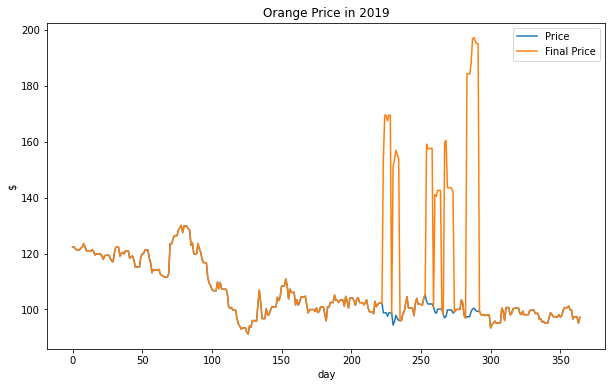

In [15]:
orange_price[['Price', 'Final Price']].plot(figsize=(10, 6))
plt.title('Orange Price in 2019')
plt.ylabel('$')
plt.xlabel('day')

In [16]:
price_strategy = pricing.Price(MAX_PRICE)

In [17]:
def arrival(env, price_strategy, inventory_class, demand_attr, arrival_attr, linear_a, constant_price, profit, seed):
    customers = demand.Customers(seed, demand_attr, arrival_attr)
    arrival_time = customers.get_arrival()

    for a in arrival_time:
        yield env.timeout(a)
        price_kwargs = {'constant_price': constant_price, 'current_inventory': inventory_class.get_current_volume(), 'a': linear_a}
        current_price = price_strategy.constant_price(**price_kwargs)
#         current_price = price_strategy.linear_price(**price_kwargs)
        current_freshness = inventory_class.get_freshness(int(env.now))
        
        
        current_demand = customers.get_demand(current_price, current_freshness)
        profit.append(min(current_demand, inventory_class.get_current_volume()) * current_price)
        inventory_class.selling(current_demand)
        
        print(env.now, '\t', current_price, '\t', int(current_freshness), '\t', current_demand, '\t', inventory_class.get_current_volume())
        
        

def refill(env, inventory_class, refill_percentage, cost, orange_price, refill_units, starting_units):
    inventory_class.refill(0, starting_units)
    cost.append(orange_price.loc[0] * starting_units)
    
    while True:
        yield env.timeout(1)
        if inventory_class.get_current_volume() <= inventory_class.size * refill_percentage:
            inventory_class.refill(env.now, refill_units)
            cost.append(orange_price.loc[int(env.now)] * refill_units)

In [18]:
cost = []
profit = []
inventory_class = inventory.Inventory(size=MAX_INVENTORY)
refill_percentage = 0.08
refill_units = 50
starting_units = 60

env = simpy.Environment()
env.process(arrival(env, price_strategy, inventory_class, demand_attr, arrival_attr, LINEAR_PRICE_BETA, CONSTANT_PRICE, profit, seed))
env.process(refill(env, inventory_class, refill_percentage, cost, orange_price['Final Price'], refill_units, starting_units))
env.process(inventory_class.inventory_process(env))
env.run(until=365)

0.012291418031634457 	 125 	 100 	 4 	 56
0.034125465638209805 	 125 	 100 	 49 	 7
0.06555388533270133 	 125 	 100 	 49 	 0
0.09957720744738152 	 125 	 0 	 0 	 0
0.16926857847739185 	 125 	 0 	 0 	 0
0.3176451911963616 	 125 	 0 	 0 	 0
0.49483094310694165 	 125 	 0 	 0 	 0
0.6955126674099351 	 125 	 0 	 0 	 0
0.9403548664245671 	 125 	 0 	 0 	 0
1.1906511410090717 	 125 	 100 	 9 	 41
1.4529575887639337 	 125 	 100 	 45 	 0
1.71926475692793 	 125 	 0 	 0 	 0
2.0073957422221773 	 125 	 100 	 56 	 0
2.3083469963513696 	 125 	 0 	 0 	 0
2.615540183791104 	 125 	 0 	 0 	 0
2.9228633076643677 	 125 	 0 	 0 	 0
3.2475865596486555 	 125 	 100 	 18 	 32
3.577043283300546 	 125 	 100 	 18 	 14
3.9149767101407713 	 125 	 100 	 41 	 0
4.273343949766324 	 125 	 100 	 44 	 6
4.636389993466976 	 125 	 100 	 52 	 0
5.0175101978605365 	 125 	 100 	 17 	 33
5.400821963332594 	 125 	 100 	 52 	 0
5.786098206541936 	 125 	 0 	 0 	 0
6.17163913919379 	 125 	 100 	 20 	 30
6.55744132965312 	 125 	 100 	 

In [10]:
sum(profit) - sum(cost)

48127.72385020554

In [20]:
profit

[500,
 6125,
 875,
 0,
 0,
 0,
 0,
 0,
 0,
 1125,
 5125,
 0,
 6250,
 0,
 0,
 0,
 2250,
 2250,
 1750,
 5500,
 750,
 2125,
 4125,
 0,
 2500,
 3750,
 0,
 4875,
 1375,
 2125,
 3500,
 2125,
 375,
 4375,
 0,
 5375,
 875,
 1375,
 1500,
 1250,
 1125,
 1000,
 1875,
 4375,
 0,
 5125,
 7000,
 375,
 3125,
 3125,
 0,
 5125,
 6875,
 3125,
 3625,
 1625,
 2625,
 6500,
 2000,
 4250,
 250,
 3250,
 4500,
 6250,
 6250,
 6250,
 0,
 2625,
 2125,
 6375,
 1875,
 5750,
 875,
 3500,
 500,
 2000,
 2375,
 3250,
 3500,
 2750,
 0,
 4625,
 1125,
 2375,
 2375,
 5750,
 2500,
 3750,
 1250,
 7000,
 5375,
 4500,
 3125,
 5875,
 625,
 3375,
 1875,
 7000,
 3125,
 2000,
 4125,
 3250,
 6250,
 375,
 5250,
 4000,
 2875,
 6250,
 3250,
 3000,
 4750,
 6125,
 7250,
 5625,
 250,
 6000,
 1750,
 5750,
 6250,
 5125,
 1500,
 125,
 5375,
 1875,
 875,
 3500,
 3125,
 2125,
 4500,
 500,
 2625,
 4000,
 2250,
 0,
 5625,
 4000,
 875,
 4750,
 1125,
 125,
 2250,
 625,
 1375,
 750,
 1750,
 4750,
 1500,
 4000,
 4000,
 4375,
 750,
 6750,
 6375,
 22

In [21]:
cost

[7344.0,
 6120.0,
 6082.5,
 6065.0,
 6065.0,
 6065.0,
 6097.5,
 6115.0,
 6177.5,
 6114.0,
 6050.0,
 6050.0,
 6045.0,
 5992.5,
 5992.5,
 5992.5,
 5960.0,
 5895.0,
 5957.5,
 5970.0,
 5970.0,
 5917.5,
 5850.0,
 6112.5,
 6112.5,
 5952.5,
 6000.0,
 5992.5,
 6047.5,
 5917.5,
 5955.0,
 5760.0,
 5992.5,
 6065.0,
 5832.5,
 5702.5,
 5717.5,
 5632.5,
 5597.5,
 5577.5,
 5647.5,
 6320.0,
 6320.0,
 6505.0,
 6492.5,
 6442.5,
 6190.0,
 5995.0,
 6082.5,
 5837.5,
 5837.5,
 5470.0,
 5357.5,
 5335.0,
 5372.5,
 5362.5,
 5302.5,
 5022.5,
 4740.0,
 4671.5,
 4679.0,
 5345.0,
 4837.5,
 4985.0,
 5220.0,
 5365.0,
 5225.0,
 4990.0,
 4962.5,
 4965.0,
 4795.0,
 5045.0,
 5125.0,
 5205.0,
 4925.0,
 5115.0,
 4925.0,
 5025.0,
 5025.0,
 7875.042025326681,
 7128.951407689566,
 5005.0,
 7177.154152228991,
 5002.5,
 9212.93451380873,
 9754.494762788861,
 4907.5,
 4902.5,
 4757.5,
 5034.0,
 4907.5,
 4907.5,
 4832.5,
 4757.5,
 4865.0,
 4992.5]